# Solar Normalization of Spot Emergence

The numbers we care about are 
- `activity_level` (= 1 for the Sun by definition)
- `alpha_med` (which parametrizes the average spot contrast * area)

We will calibrate the `activity_level` such that the monthly spot count equals that measured for the Sun. For `alpha_med`, we just need the average contrast * area for a typical sunspot.

Other important numbers and where to find them:
- `cycle_period` (`emerge_regions`): the time between successive cycle starts, 11 years (Schwabe 1844).
- `cycle_overlap` (`emerge_regions`): the time between the beginning of cycle `i+1` and the end of cycle `i`. The number in my head was 2 years, but [another source](https://spaceweatherarchive.com/2022/12/14/a-new-paradigm-for-solar-activity-the-extended-solar-cycle/) suggests 6 (making the start to end of a single cycle 17 years). I'm leaving this at 2 years for now.
- `max_lat` (`emerge_regions`): the median latitude of spot emergence at the beginning of a cycle. (This paper)[https://arxiv.org/pdf/1604.00831.pdf] has it at roughly 25 +/- 10 degrees (2σ spread).
- `min_lat` (`emerge_regions`): the median latitude of spot emergence at the end of a cycle. The source cited above has roughly 10 +/- 10 degrees (again 2σ spread).
- `prob_corr` (`emerge_regions`): parametrizes the emergence rate of "correlated" active regions relative to "uncorrelated" regions. I've seen 0.001 and 0.0001 in the code I inherited, but I have yet to find a source for this. If I recall correctly, most active regions emerge near existing (or recently existing) regions, so this number should probably be higher.
- `period` (`evolve_spots`): equatorial rotation period. The Sun's siderial period is 24.47 days, but the synodic period is 26.24 days. Depending on how historical spot counts are tabulated, we will use one or the other.
- `shear` (`evolve_spots`): the differential rotation shear = ($\Omega_{pole}$ - $\Omega_{eq}$) / $\Omega_{eq}$. For the Sun, this is roughly (30 d - 25 d) / 25 d = 0.2
- `tau_evol` (`evolve_spots`): the spot decay time scaled by the equatorial period. I'm not sure what this is for the Sun, but I have 5 periods (= 125 d) by default, which is probably too long for the Sun.

In [1]:
import numpy as np
import butterpy as bp

In [3]:
np.random.seed(88)

duration = 100*365
s = bp.Surface()
r = s.emerge_regions(
    ndays=duration, 
    activity_level=1, 
    cycle_period=11, 
    cycle_overlap=2, 
    max_lat=28, 
    min_lat=7,
    prob_corr=0.001)

In [4]:
time = np.arange(0, duration, 30.0)
l = s.evolve_spots(time, period=24.5, alpha_med=1e-4, shear=0.2, tau_evol=0.1)

[SpaceWeatherLive](https://www.spaceweatherlive.com/en/solar-activity/solar-cycle/historical-solar-cycles.html) shows the 13-month smoothed International Sunspot Number since the 18th century. It varies from about 0 at minimum to 100--200 at maximum. Let's say the median is about 150. Then we need to set the normalization factor such that our measured ISN maxes at 150.

Note from NOAA: The international sunspot number is produced by the Solar Influences Data Analysis Center (SIDC), World Data Center for the Sunspot Index, at the Royal Observatory of Belgium. We kindly request that you acknowledge the SIDC when using these data. Please refer to the SIDC site for additional information. The SIDC requests users of the data to credit: SIDC, RWC Belgium, World Data Center for the Sunspot Index, Royal Observatory of Belgium, [year(s)-of-data] (1760 - 2014).

We will consider all spots at a given time that are greater than some area threshold. [Hathaway 2015](https://ui.adsabs.harvard.edu/abs/2015LRSP...12....4H/abstract) Fig. 47 has the smallest sunspots at about 10 $\mu$Hem (10 millionths of a hemisphere), so we'll use that as our threshold.

  0%|                                                                                | 0/1217 [00:00<?, ?it/s]/tmp/ipykernel_190613/3557536236.py:10: RuntimeWarning: invalid value encountered in divide
  beta = -dF/area
100%|█████████████████████████████████████████████████████████████████████| 1217/1217 [00:40<00:00, 29.69it/s]


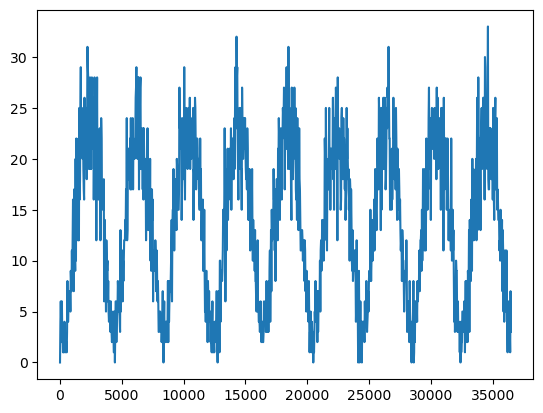

In [5]:
from tqdm import tqdm

time = np.arange(0, duration, 30.0)
 

threshold = 1e-6
N = []
for t in tqdm(time):
    lat, phase, area, dF = s._calc_t(t, animate=True)
    beta = -dF/area
    N.append(sum((area > threshold) & (beta > 0)))
    
    
import matplotlib.pyplot as plt
plt.figure()
plt.plot(time, N)

When I don't include the threshold, there are an order of magnitude more spots... maybe I need to make spots below the threshold disappear. Say they drop below a certain area, then poof. Since most flux modulation comes from larger spots/groups, this should be fine...

Consider spot lifetime module to scale lifetimes by the maximum area (https://www.sws.bom.gov.au/Educational/2/2/2, Gnevyshev-Waldmeier)

See https://www.aanda.org/articles/aa/full_html/2021/09/aa40731-21/aa40731-21.html for discussion of spot areas and lifetimes.

<IPython.core.display.Javascript object>


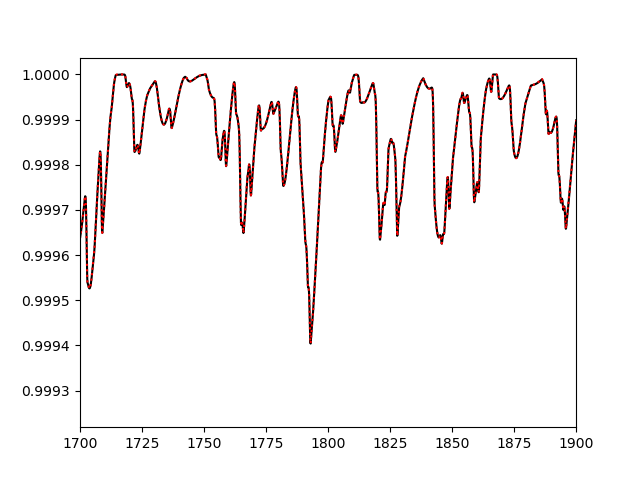

(1700.0, 1900.0)

In [72]:
def alt_calc_i(self, time, i, threshold=1e-6):
    """
    Helper function to evolve one spot and calculate its impact on the flux.

    Includes rotation and foreshortening (i.e., spots in the center cause
    more modulation than spots at the limb, and spots out of view do not
    contribute flux modulation). Also includes spot emergence and decay.

    Currently there is no spot drift or shear (within an active region).

    Parameters
    ----------
    time (numpy array):
        the array of time values at which to compute the flux modulation.

    i (int):
        spot index, which can have integer values of [0, self.nspot].

    Returns
    -------
    dF_i (numpy array):
        the time-varying flux modulation from spot `i`.
    """
    tt = time - self.tmax[i]
    # Spot area
    area = self.amax[i] * self.spot_evol(tt, self.tau_emerge, self.tau_decay)
    area[area < threshold] = 0
    # Rotation rate
    omega_lat = self.diffrot_func(self.omega, self.shear, self.lat[i])
    phase = omega_lat * time * 24*3600 + self.lon[i]
    # Foreshortening
    beta = np.cos(self.incl) * np.sin(self.lat[i]) + \
        np.sin(self.incl) * np.cos(self.lat[i]) * np.cos(phase)
    # Differential effect on stellar flux
    dF_i = -area*beta
    dF_i[beta < 0] = 0
    return dF_i


time = np.arange(0, 5000, 0.1)
f1 = s.compute_lightcurve(time).flux

f2 = np.ones_like(time, dtype="float32")
for i in np.arange(s.nspots):
    f2 += alt_calc_i(s, time, i, threshold=1e-6)
    
plt.figure()
plt.plot(time, f1, "k", time, f2, "r:")
plt.xlim(1700, 1900)

<IPython.core.display.Javascript object>


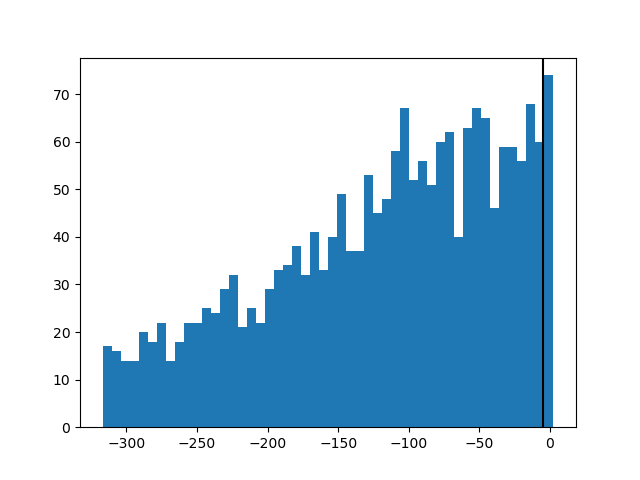

In [45]:
%matplotlib notebook
plt.figure()
plt.hist(np.log10(1e6*area[area>0]), bins=50)
plt.axvline(-5, color="k");

In [4]:
def spot_counts(time, counts, bin_size=30, threshold=1e-5, make_plot=True):
    """
    Compute and plot the monthly spot number.
    Copied and edited from `butterpy.utils.plots.spot_counts`.

    Following Hathaway (2015), LRSP 12: 4, we compute the number of spots
    emerging in a particular month, then smooth the time series with a
    sliding 13-month window, centered on each month. This corresponds to 
    the "International Sunspot Number" (see section 3.1).

    This function generalizes the spot count window size, but keeps 
    the month window by default. 

    Parameters
    ----------
    time (array):
        Array of time values corresponding to spot counts.
        
    counts (list):
        List of spot counts computed at each time value.

    bin_size (float, 30):
        The window length in days for the spot count.

    threshold (float, 1e-5): 
        only count spots larger than a certain size. 
        Default is 10 millions of a Solar hemisphere.
    
    make_plot (bool, optional, default=True):
        Whether to make and display the plot.

    Returns
    -------
    T (array):
        The times corresponding to each spot count.

    N (array):
        The monthly spot counts.
    """
    days = spots["nday"]

    # first bin spot counts by month
    d = bin_size/2
    time = []
    nspots = []
    while d < days.max():
        time.append(d)
        nspots.append(sum((d-bin_size/2 < days) & (days <= d+bin_size/2)))
        d += bin_size
    
    # smooth monthly spot counts
    time = np.array(time)
    nspots = np.array(nspots)
    bin_size *= 13
    d = bin_size/2 
    T = []
    N = []
    while d < days.max():
        T.append(d/365)
        N.append(np.mean(nspots[((d-bin_size/2) < time) & (time <= (d+bin_size/2))]))
        d += bin_size/13

    if make_plot:
        plt.figure()
        plt.plot(time/365, nspots, "ko", ms=3, label="Monthly Spot Count")
        plt.plot(T, N, "r", label="13-Month Smoothing")
        plt.xlabel("Time (years)")
        plt.ylabel("Monthly Sunspot Number")
        plt.legend()
        plt.show()

    return np.array(T), np.array(N)